# Import libraries

In [1]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
import os
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import shutil
import random as rn
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Load dataset from Google Drive
The dataset is stored in Google Drive in a zip file, we unzip it locally for better performance.

In [2]:
drive.mount('/content/drive', force_remount=True)
!unzip -q '/content/drive/My Drive/Baldi_Cioffo/SplittedDataset.zip' -d '/content'

Mounted at /content/drive


# Set parameters

In [3]:
DATASET_PATH = "/content/SplittedDataset"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/Baldi_Cioffo/models/from_scratch"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300

# Utility functions

In [4]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def load_training_set (image_height, image_width, batch_size):
  '''
  load_training_set loads the training set from the "training_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the training set
  '''
  return image_dataset_from_directory(
    TRAINING_PATH,
    image_size = (image_height, image_width), # 300x300
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all 

def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the validation set
  '''
  return image_dataset_from_directory(
    VALIDATION_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all 

def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the test set
  '''
  return image_dataset_from_directory(
    TEST_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle=False,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  show_training_and_validation_performance(history)

def evaluate_model (model):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(test_dataset)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

# Analyze shapes of the images in the training set
After the preprocessing phase, we have images of different shapes, we need to find the best size to feed into the neural network. To do this, we decided to analyze the shapes of our training pictures.

In [ ]:
shapes = {} 

total_entries = []
entries = os.listdir(TRAINING_ALL_PATH)
total_entries += entries
for entry in tqdm(entries):
  img = cv2.imread(TRAINING_ALL_PATH + '/' + entry)
  if img.shape <= (300, 300):
    shapes[(300,300)] = shapes.get((300,300), 0) + 1
  if img.shape <= (299, 299): # like Inception and Xception
    shapes[(299,299)] = shapes.get((299,299), 0) + 1
  if img.shape <= (224, 224): # like ResNet, DenseNet, VGG, EfficientNet
    shapes[(224,224)] = shapes.get((224,224), 0) + 1
entries = os.listdir(TRAINING_HEM_PATH)
total_entries += entries
for entry in tqdm(entries):
  img = cv2.imread(TRAINING_HEM_PATH + '/' + entry)
  if img.shape <= (300, 300):
    shapes[(300,300)] = shapes.get((300,300), 0) + 1
  if img.shape <= (299, 299):
    shapes[(299,299)] = shapes.get((299,299), 0) + 1
  if img.shape <= (224, 224):
    shapes[(224,224)] = shapes.get((224,224), 0) + 1

  0%|          | 0/3198 [00:00<?, ?it/s]

  0%|          | 0/3198 [00:00<?, ?it/s]

In [ ]:
print("Number of training images: ", len(total_entries))
print("Common shapes: ", shapes)

Number of training images:  6396
Common shapes:  {(300, 300): 6190, (299, 299): 6180, (224, 224): 3856}


Out of 6396 images in the training set, 6190 are at most 300x300. We decided that 300x300 is a good shape for the input layer of the neural network.

# CNN Implementation
In the next sections we are going to perform various experiments. Many architectures have been tried, but only the bests have been reported. All reported models follow the same convolutional scheme, with increasing max pooling. The differences can be seen in the final levels of the networks, where the classification on the features extracted from the images actually takes place.

## Load dataset

In [5]:
set_seed()

train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE) # with default values
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE) # with default values
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


## Experiment 1: one dense layer with 256 neurons and one dropout
We try a simple model with a single dense layer of 256 neurons and dropout to fight the high overfitting.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3,3))(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(5,5))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu') (x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

compile_model(model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 150, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                       

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.5086
Epoch 00001: val_loss improved from inf to 0.68463, saving model to /content/models/prova.h5
200/200 [==============================] - 65s 256ms/step - loss: 0.6938 - accuracy: 0.5086 - val_loss: 0.6846 - val_accuracy: 0.6628
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.6742 - accuracy: 0.5766
Epoch 00002: val_loss improved from 0.68463 to 0.64231, saving model to /content/models/prova.h5
200/200 [==============================] - 48s 236ms/step - loss: 0.6742 - accuracy: 0.5766 - val_loss: 0.6423 - val_accuracy: 0.6501
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.6048 - accuracy: 0.6750
Epoch 00003: val_loss improved from 0.64231 to 0.58783, saving model to /content/models/prova.h5
200/200 [==============================] - 46s 230ms/step - loss: 0.6048 - accuracy: 0.6750 - val_loss: 0.5878 - val_accuracy: 0.7106
Epoch 4/30
200/200 [===

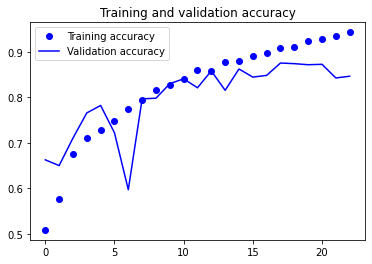

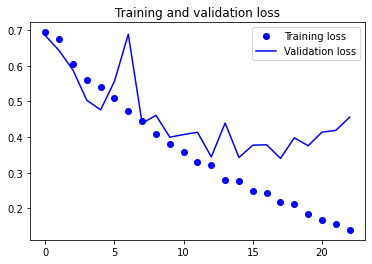

In [ ]:
run_model(model, "OneDense256_1dropout", epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.7994    0.8132    0.8063       696
           1     0.9088    0.9012    0.9050      1437

    accuracy                         0.8725      2133
   macro avg     0.8541    0.8572    0.8556      2133
weighted avg     0.8731    0.8725    0.8728      2133



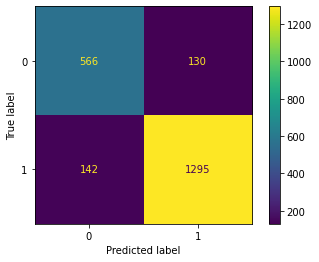

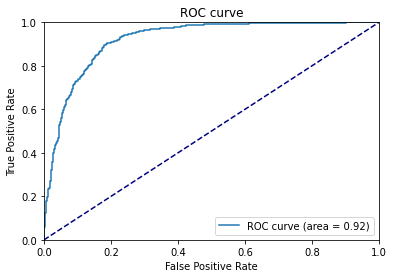

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense256_1dropout.h5'))

## Experiment 2: one dense layer with 256 neurons and two dropouts
In the last experiment we can still see overfitting, we try to insert another dropout before the dense layer with 256 neurons.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3,3))(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(5,5))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu') (x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                         

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.5647
Epoch 00001: val_loss improved from inf to 0.62381, saving model to /content/models/OneDense256_L2reg.h5
200/200 [==============================] - 44s 216ms/step - loss: 0.6763 - accuracy: 0.5647 - val_loss: 0.6238 - val_accuracy: 0.6548
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.6925
Epoch 00002: val_loss improved from 0.62381 to 0.56114, saving model to /content/models/OneDense256_L2reg.h5
200/200 [==============================] - 43s 215ms/step - loss: 0.5846 - accuracy: 0.6925 - val_loss: 0.5611 - val_accuracy: 0.7387
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.5461 - accuracy: 0.7328
Epoch 00003: val_loss did not improve from 0.56114
200/200 [==============================] - 44s 217ms/step - loss: 0.5461 - accuracy: 0.7328 - val_loss: 0.6001 - val_accuracy: 0.6904
Epoch 4/30
200/200 [=========================

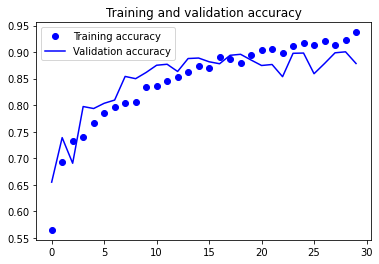

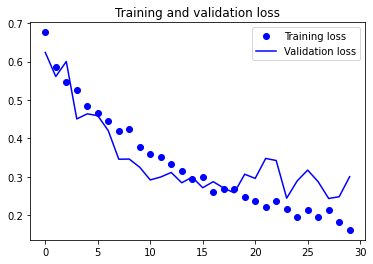

In [ ]:
run_model(model, "OneDense256_2dropout", epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.8754    0.8376    0.8561       696
           1     0.9230    0.9422    0.9325      1437

    accuracy                         0.9081      2133
   macro avg     0.8992    0.8899    0.8943      2133
weighted avg     0.9074    0.9081    0.9076      2133



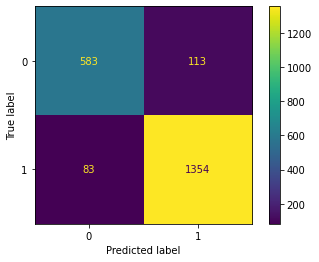

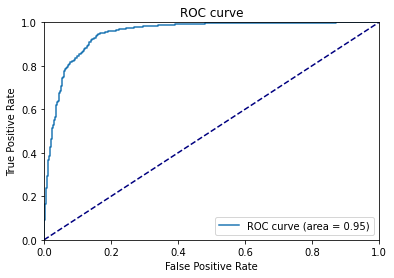

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense256_2dropout.h5'))

## Experiment 3: one dense layer with 128 neurons and dropout
To fight overfitting, we try to decrease the number of neurons in the dense layer

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3,3))(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(5,5))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu') (x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                         

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.4983
Epoch 00001: val_loss improved from inf to 0.69427, saving model to /content/models/prova.h5
200/200 [==============================] - 73s 299ms/step - loss: 0.6942 - accuracy: 0.4983 - val_loss: 0.6943 - val_accuracy: 0.3419
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4948
Epoch 00002: val_loss improved from 0.69427 to 0.69401, saving model to /content/models/prova.h5
200/200 [==============================] - 56s 279ms/step - loss: 0.6932 - accuracy: 0.4948 - val_loss: 0.6940 - val_accuracy: 0.3419
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.5261
Epoch 00003: val_loss improved from 0.69401 to 0.62614, saving model to /content/models/prova.h5
200/200 [==============================] - 56s 277ms/step - loss: 0.6881 - accuracy: 0.5261 - val_loss: 0.6261 - val_accuracy: 0.6637
Epoch 4/100
200/200 

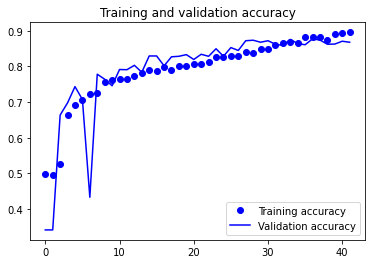

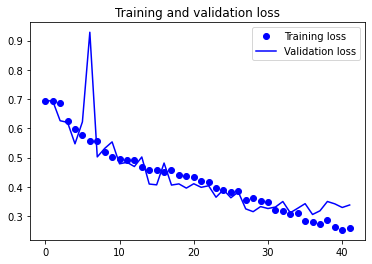

In [ ]:
run_model(model, "OneDense128_2dropout", epochs=100)

Classification report: 
              precision    recall  f1-score   support

           0     0.8682    0.6911    0.7696       696
           1     0.8638    0.9492    0.9045      1437

    accuracy                         0.8650      2133
   macro avg     0.8660    0.8201    0.8371      2133
weighted avg     0.8653    0.8650    0.8605      2133



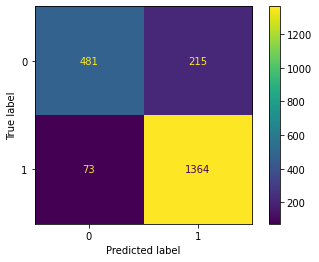

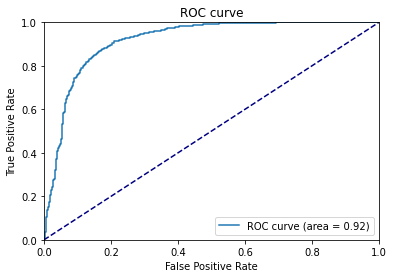

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense128_2dropout.h5'))

## Experiment 4: two dense layers 
We can try to increase the number of dense layers.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3,3))(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(5,5))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu') (x)
x = layers.Dense(256, activation='relu') (x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 150, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                       

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.5907
Epoch 00001: val_loss improved from inf to 0.62138, saving model to /content/models/TwoDense_256.h5
200/200 [==============================] - 48s 230ms/step - loss: 0.6550 - accuracy: 0.5907 - val_loss: 0.6214 - val_accuracy: 0.7420
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.5826 - accuracy: 0.6907
Epoch 00002: val_loss did not improve from 0.62138
200/200 [==============================] - 47s 235ms/step - loss: 0.5826 - accuracy: 0.6907 - val_loss: 0.6256 - val_accuracy: 0.7036
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.5494 - accuracy: 0.7169
Epoch 00003: val_loss improved from 0.62138 to 0.56394, saving model to /content/models/TwoDense_256.h5
200/200 [==============================] - 48s 240ms/step - loss: 0.5494 - accuracy: 0.7169 - val_loss: 0.5639 - val_accuracy: 0.7434
Epoch 4/30
200/200 [==============================] - E

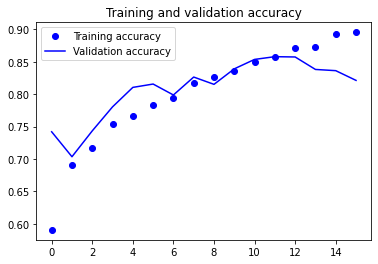

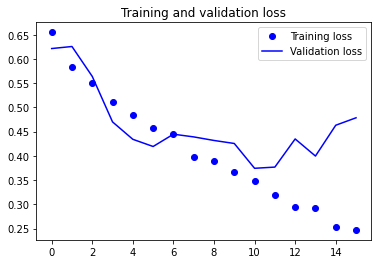

In [ ]:
run_model(model, "TwoDense_256", epochs=30)

Classification report: 
              precision    recall  f1-score   support

           0     0.7884    0.7227    0.7541       696
           1     0.8709    0.9061    0.8881      1437

    accuracy                         0.8462      2133
   macro avg     0.8297    0.8144    0.8211      2133
weighted avg     0.8440    0.8462    0.8444      2133



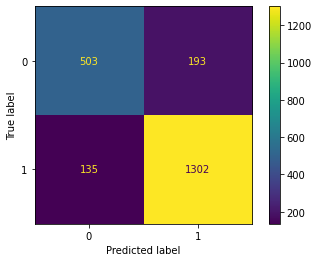

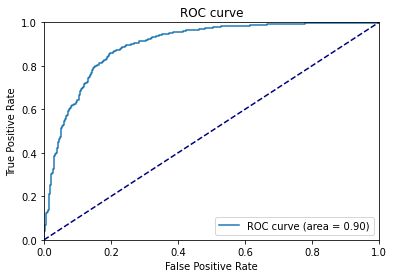

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/TwoDense_256.h5'))

## Experiment 5: two dense layer, the first with less neurons

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3,3))(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(5,5))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu') (x)
x = layers.Dense(256, activation='relu') (x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 150, 150, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                      

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.5167
Epoch 00001: val_loss improved from inf to 0.60424, saving model to /content/models/TwoDense_128_256.h5
200/200 [==============================] - 44s 216ms/step - loss: 0.6911 - accuracy: 0.5167 - val_loss: 0.6042 - val_accuracy: 0.7369
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.6420
Epoch 00002: val_loss improved from 0.60424 to 0.57427, saving model to /content/models/TwoDense_128_256.h5
200/200 [==============================] - 43s 214ms/step - loss: 0.6322 - accuracy: 0.6420 - val_loss: 0.5743 - val_accuracy: 0.7575
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.6843
Epoch 00003: val_loss improved from 0.57427 to 0.55075, saving model to /content/models/TwoDense_128_256.h5
200/200 [==============================] - 43s 213ms/step - loss: 0.5956 - accuracy: 0.6843 - val_loss: 0.5508 - val_accurac

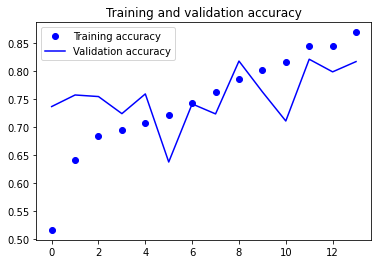

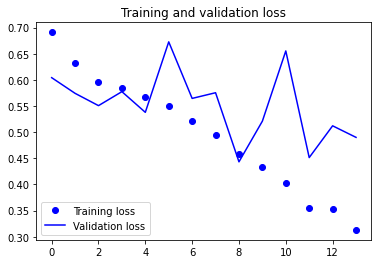

In [ ]:
run_model(model, "TwoDense_128_256", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.7578    0.6250    0.6850       696
           1     0.8326    0.9033    0.8665      1437

    accuracy                         0.8125      2133
   macro avg     0.7952    0.7641    0.7758      2133
weighted avg     0.8082    0.8125    0.8073      2133



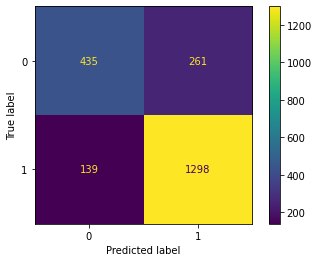

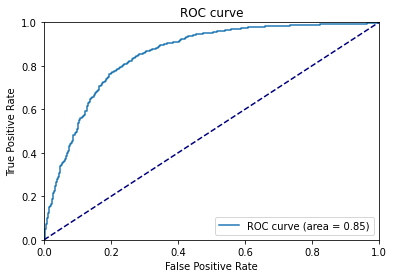

In [6]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/TwoDense_128_256.h5'))

# CLAHE
We will try now to use the dataset in which the images are preprocesses with CLAHE. We will test the performance with the best network previuosly found and we will compare the results.

## Load dataset from Google Drive
The dataset is stored in Google Drive in a zip file, we unzip it locally for better performance.

In [ ]:
drive.mount('/content/drive', force_remount=True)
!unzip -q '/content/drive/My Drive/Baldi_Cioffo/SplittedDataset_CLAHE.zip' -d '/content'

Mounted at /content/drive


## Set parameters

In [ ]:
DATASET_PATH = "/content/SplittedDataset_CLAHE"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

## Load dataset

In [ ]:
set_seed()

train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE) # with default values
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE) # with default values
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


## Experiment increasing MaxPooling with two dropout

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2,2))(x)
x = layers.Conv2D(filters=128, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(3,3))(x)
x = layers.Conv2D(filters=256, padding='same', kernel_size=(3,3), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(5,5))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu') (x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                         

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.5073
Epoch 00001: val_loss improved from inf to 0.68611, saving model to /content/models/OneDense256_2dropout_CLAHE.h5
200/200 [==============================] - 57s 229ms/step - loss: 0.6946 - accuracy: 0.5073 - val_loss: 0.6861 - val_accuracy: 0.6764
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.6123
Epoch 00002: val_loss improved from 0.68611 to 0.58582, saving model to /content/models/OneDense256_2dropout_CLAHE.h5
200/200 [==============================] - 43s 215ms/step - loss: 0.6550 - accuracy: 0.6123 - val_loss: 0.5858 - val_accuracy: 0.7430
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.6022 - accuracy: 0.6765
Epoch 00003: val_loss improved from 0.58582 to 0.52053, saving model to /content/models/OneDense256_2dropout_CLAHE.h5
200/200 [==============================] - 43s 215ms/step - loss: 0.6022 - accuracy: 0.6765 - 

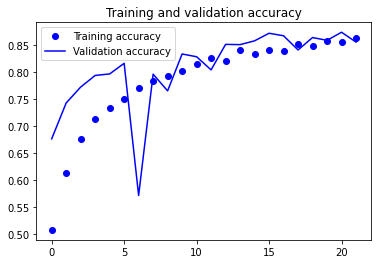

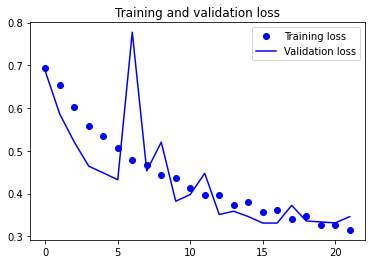

In [ ]:
run_model(model, "OneDense256_2dropout_CLAHE", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.8382    0.7443    0.7884       696
           1     0.8825    0.9304    0.9058      1437

    accuracy                         0.8697      2133
   macro avg     0.8603    0.8373    0.8471      2133
weighted avg     0.8680    0.8697    0.8675      2133



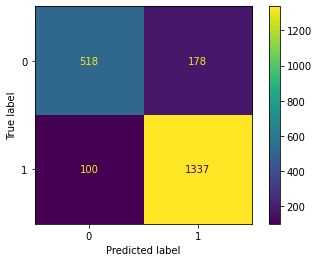

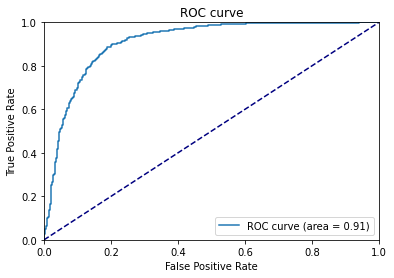

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/OneDense256_2dropout_CLAHE.h5'))